# **Trabalho \#1**: Deep Learning MO434/MC934
Universidade Estadual de Campinas (UNICAMP), Instituto de Computação (IC)

Profa. Sandra Avila, 2020s2





In [ ]:
print('211518: ' + 'Stephane de Freitas Schwarz')
print('121245: ' + 'Nícolas Riccieri Gardin Assumpção')

211518: Stephane de Freitas Schwarz
121245: Nícolas Riccieri Gardin Assumpção


## Objetivo

Treinar e explorar o comportamento de diferentes componentes que integram uma **Rede Neural Convolucional (CNN)**, usando um subconjunto do dataset de lesões de pele ISIC Challenge 2017, classificando lesões malignas × benignas.

## Dataset

O dataset ISIC Challenge 2017 contém 2.000 imagens com 3 diagnósticos de lesão: nevos, ceratose seborreica e melanoma. Dessas, apenas melanoma é maligna. 

Para este trabalho vamos considerar apenas a **classificação binária** de malignas × benignas. Utilize o conjunto de validação para avaliar seus experimentos intermediários, e apenas no fim, use o teste. Informações sobre o dataset estão disponíveis em https://challenge.isic-archive.com/landing/2017/44.

A métrica oficial da base de dados é a AUC (_Area Under the ROC Curve_).

## Deadline

Segunda-feira, 7 de Dezembro 14h (antes da aula). 

Política de penalidade para submissões atrasadas: Você não está sendo encorajada(o) a submeter trabalho depois da data de submissão. Entretanto, caso isso aconteça, a nota será penalizada da seguinte forma:
- 8 de Dezembro 14h : nota * 0,75
- 9 de Dezembro 14h : nota * 0,5
- 10 de Dezembro 14h : nota * 0,25


## Submissão

Submeta o Jupyter Notebook (em Português ou Inglês) no Google Classroom.

**O trabalho NÃO é individual, deve ser feito em dupla.**

## Carregamento dos Dados

Os .zips contendo o dataset está no google drive. O código abaixo faz o download, e extrai o zip. Note que você precisará logar no Google para que esse processo seja possível. Caso haja alguma falha ou erro no processo, reinicie o notebook, e tente novamente.

Depois desse processo, teremos no diretório:

*   isic2017-train: 2000 imagens. 
*   isic2017-val:    150 imagens.
*   isic2017-test:   650 imagens.

## Import dataset

In [ ]:
!pip install PyDrive &> /dev/null

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1EH2tlRi4Iqq8WfLOXl6hMc5jTeiIRzaW"})
downloaded.GetContentFile('isic2017-trainval.zip')
!unzip -q isic2017-trainval.zip

downloaded = drive.CreateFile({'id':"1uP1tCj6-T2FXxk7g7gqoC_SGOhqIQyrM"})   
downloaded.GetContentFile('isic2017-test.zip')       
!unzip -q isic2017-test.zip

Em cada diretório, temos uma pasta contendo as lesões benignas ('/benign') e outra contendo as lesões malignas ('/malignant'). A separação dessa forma facilita a importação dos dados utilizando o keras.

Note que o conjunto é altamente desbalanceado. Talvez seja adequado aplicar aumentação de dados nas imagens.

Para aumentação de dados, recomenda-se o uso da ImageDataGenerator do Keras, pois ela facilita o uso de aumentação e pré-processamento dos dados.


## Atividades

1. (1,0) Construa uma rede neural convolucional para baseline. Sugestão: comece por uma arquitetura simples. Quanto mais simples, melhor.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as K
import tensorflow.keras.layers as L

import pandas as pd
import numpy as np
import sklearn as skl

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 16]
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style="whitegrid")

In [ ]:
# Baseline without augmentation.
train_datagenerator = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagenerator.flow_from_directory('isic2017-train',
                                                          target_size=(299,299),
                                                          batch_size=32,
                                                          class_mode='binary')

validation_datagenerator = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagenerator.flow_from_directory('isic2017-val',
                                                          target_size=(299,299),
                                                          batch_size=32,
                                                          class_mode='binary')

test_datagenerator = ImageDataGenerator(rescale=1.0/255.0)
test_generator = train_datagenerator.flow_from_directory('isic2017-test',
                                                          target_size=(299,299),
                                                          batch_size=32,
                                                          class_mode='binary')

from sklearn.utils.class_weight import compute_class_weight
weights = dict(enumerate(compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)))

EPOCHS = 40

Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
import numpy as np
print("training set: "+str({k: v for k,v in zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes))}))
print("validation set: "+str({k: v for k,v in zip(train_generator.class_indices.keys(), np.bincount(validation_generator.classes))}))
print("test set: "+str({k: v for k,v in zip(train_generator.class_indices.keys(), np.bincount(test_generator.classes))}))

training set: {'benign': 1626, 'malignant': 374}
validation set: {'benign': 120, 'malignant': 30}
test set: {'benign': 483, 'malignant': 117}


In [ ]:
def plot_results(history):
  ax1 = plt.subplot(4, 2, 1)
  ax2 = plt.subplot(4, 2, 2)
  ax3 = plt.subplot(4, 2, 3)
  ax4 = plt.subplot(4, 2, 4)
  ax5 = plt.subplot(4, 2, 5)
  ax6 = plt.subplot(4, 2, 6)
  ax7 = plt.subplot(4, 2, 7)
  ax8 = plt.subplot(4, 2, 8)

  for label, hist in history.items():
    ax1.plot(range(len(hist.loss)), hist.loss, label=label)
    ax3.plot(range(len(hist.loss)), hist.binary_accuracy, label=label)
    ax5.plot(range(len(hist.loss)), hist.iloc[:, 3], label=label)
    ax7.plot(range(len(hist.loss)), hist.iloc[:, 4], label=label)
    ax2.plot(range(len(hist.loss)), hist.val_loss, label=label)
    ax4.plot(range(len(hist.loss)), hist.val_binary_accuracy, label=label)
    ax6.plot(range(len(hist.loss)), hist.iloc[:, -1], label=label)
    ax8.plot(range(len(hist.loss)), hist.iloc[:, -2], label=label)

  ax1.set_title(f'Training Loss')
  ax3.set_title(f'Training Accuracy')
  ax5.set_title(f'Training AUC')
  ax7.set_title(f'Training Recall')
  ax2.set_title(f'Validation Loss')
  ax4.set_title(f'Validation Accuracy')
  ax6.set_title(f'Validation AUC')
  ax8.set_title(f'Validation Recall')
  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()
  ax5.legend()
  ax6.legend()
  ax7.legend()
  ax8.legend()
  plt.show()

In [ ]:
# Baseline approach simple neural network 
'''
Convolution
Normalization
Max Pooling
Fully connected
Normalization
Decision Make
'''

def LesionNet():
  
  n_classes = 1
  image_width = 299
  image_height = 299
  
  if K.backend.image_data_format() == 'channels_first':
    
    input_shape = (3, image_width, image_height)
  else:
    input_shape = (image_width, image_height, 3)

  model = K.Sequential()
  
  model.add(L.BatchNormalization())

  model.add(L.Conv2D(32, (4,4), strides=(1,1), activation='relu', padding='same', input_shape=input_shape))
  model.add(L.MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2)))
  
  model.add(L.BatchNormalization())
  model.add(L.Dropout(0.3))

  model.add(L.Flatten())  
  model.add(L.Dense(128, activation='relu')) 
  
  model.add(L.Dense(n_classes, activation='sigmoid'))

  opt = K.optimizers.SGD(learning_rate=1e-4, momentum=0.9, decay=1e-6)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[K.metrics.BinaryAccuracy(), 
                                                                    K.metrics.Precision(), 
                                                                    K.metrics.Recall(),
                                                                    K.metrics.AUC()])

  return model

baseline_model = LesionNet()

h = baseline_model.fit(train_generator, 
                        epochs=EPOCHS,
                        validation_data=validation_generator,
                        class_weight=weights)

Epoch 1/40
63/63 [==============================] - 13s 206ms/step - loss: 1.4836 - binary_accuracy: 0.5675 - precision: 0.2317 - recall: 0.5668 - auc: 0.5848 - val_loss: 0.7786 - val_binary_accuracy: 0.3000 - val_precision: 0.1901 - val_recall: 0.7667 - val_auc: 0.4639
Epoch 2/40
63/63 [==============================] - 12s 197ms/step - loss: 0.8095 - binary_accuracy: 0.6340 - precision: 0.2859 - recall: 0.6390 - auc: 0.6962 - val_loss: 0.6236 - val_binary_accuracy: 0.6200 - val_precision: 0.2128 - val_recall: 0.3333 - val_auc: 0.5569
Epoch 3/40
63/63 [==============================] - 12s 196ms/step - loss: 0.5846 - binary_accuracy: 0.6770 - precision: 0.3385 - recall: 0.7620 - auc: 0.7851 - val_loss: 0.5664 - val_binary_accuracy: 0.6933 - val_precision: 0.2647 - val_recall: 0.3000 - val_auc: 0.6253
Epoch 4/40
63/63 [==============================] - 12s 197ms/step - loss: 0.5223 - binary_accuracy: 0.7150 - precision: 0.3727 - recall: 0.7674 - auc: 0.8235 - val_loss: 0.5572 - val_bin

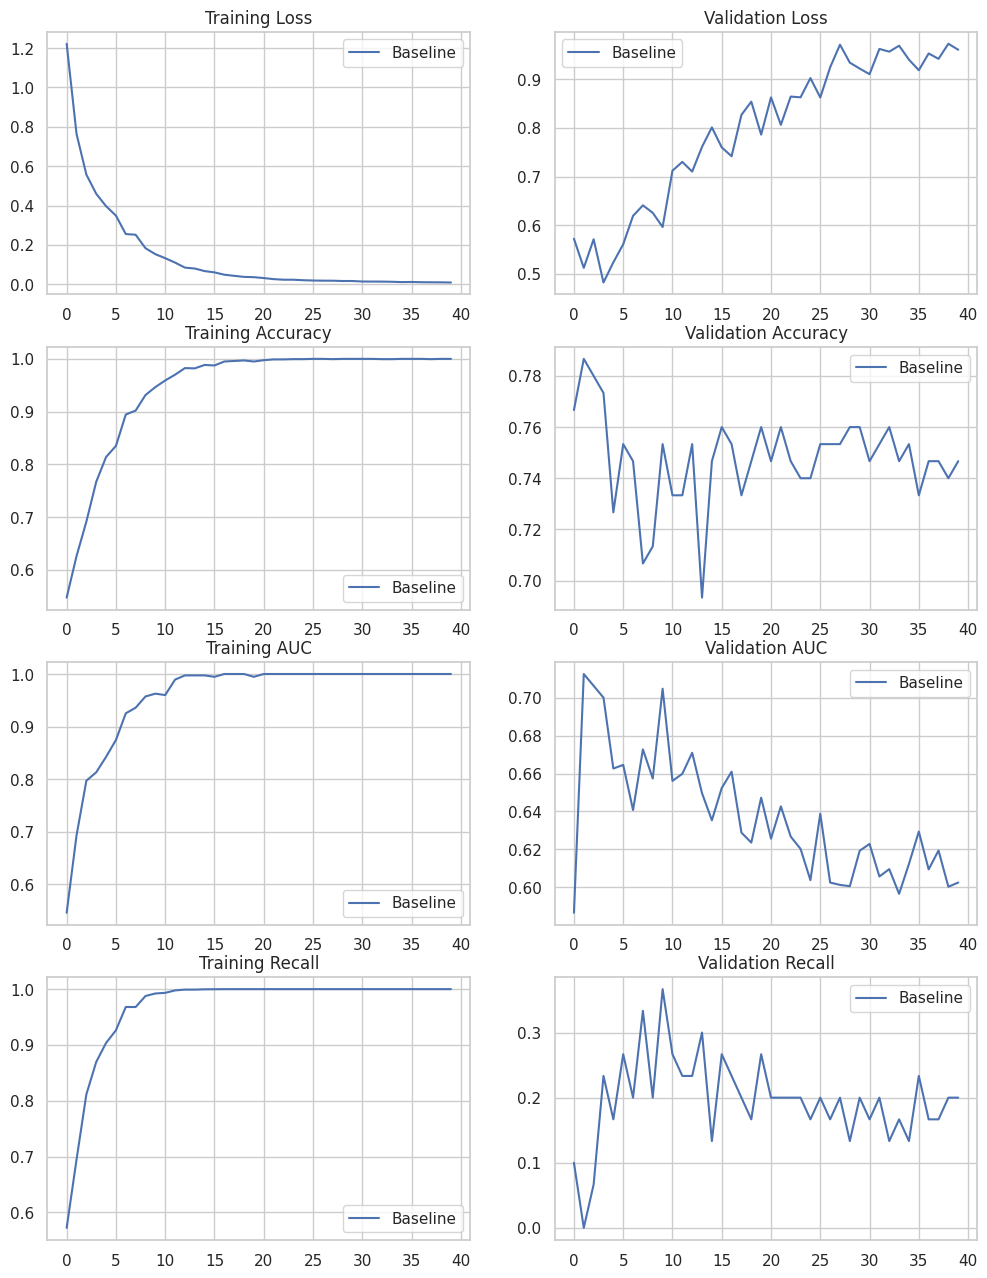

In [ ]:
baseline = {"Baseline": pd.DataFrame.from_dict(h.history)}
plot_results(baseline)


> Quais são as suas impressões? Arquitetura simples demais? Problema difícil demais? Poucos dados? (1-2 parágrafos)


---

Identificar se uma lesão de pele é maligna ou benigna não é um trabalho trivial devido a sutil variabilidade na aparência, morfologia e granularidade das lesões. Com o advento das redes neurais convolucionais profundas (DCNN), tarefas complexas podem ser resolvidas com um grau satisfatório de confiabilidade, desde que haja uma quantidade de dados suficientemente grande disponível para análise.
Os dados disponibilizados no desafio isic2017 embora tenha um número razoável de imagens, 2000 imagens para treinamento e 150 para validação do modelo, a quantidade de instâncias por classe é desproporcional. Cerca de 80% dos dados de treinamento representam lesões benignas, o mesmo ocorre no conjunto de validação. Esse desbalanceamento prejudica o desempenho do modelo. Para resolver esse impasse foi adicionado ao modelo um parâmetro que pondera as classes, com isso, a rede "presta mais atenção" às amostras menos representadas no dataset. Para modelar os dados corretamente, normalizamos os pixeis das imagens com o objetivo de limitar o intervalo das intensidades sem alterar a distribuição geral delas.

A rede proposta é composta por uma camada de Convolução com 32 filtros quadráticos com dimensões equivalentes a 4x4, seguida por uma camada que realiza a operação Max Pooling em uma janela 2x2 com saltos que observam a mesma proporção. Optamos por adicionar uma camada Fully-connected antes da camada de decisão de modo a suavizar, sutilmente, a transição entre a camada extratora de características e a camada de classificação. A ideia por trás dessa abordagem é realçar características descritivas gerais através da camada de convolução e extrair atributos de alta ordem na camada de max pooling. Além disso, adicionamos camadas de normalização por batches.

O principal desafio na elaboração dessa arquitetura foi explorar os hiperparâmetros. Começamos com uma Learning Rate igual a 0.03. A despeito de estamos usando normalização de batchs, nos pixeis da imagem e balanceando os dados, o modelo não melhorava ao longo do tempo, tanto na etapa de treinamento quanto na validação, caracterizando um underfitting. Quando, porém, reduzimos essa taxa para 0.0001, angariamos melhores resultados. Os valores de AUC na etapa de treinamento tenderam a 1 ao longo das épocas, sugerindo que a rede é capaz de distinguir entre as classes positiva e negativa. Por outro lado, na validação, os resultados de AUC variaram entre 0.5 à 0.63. Essa particularidade indica que, ou a predição é randomica ou as imagens estão sendo classificadas continuamente na mesma classe --- isso não seria uma surpresa já que 80% das imagens de melanoma são benignas. Verificamos a classificação das amostras durante a validação e constatamos que todas elas são classificadas como benignas. Validando a hipótese mencionada.

Em suma, para um problema complexo como esse acreditamos que seja necessário mais dados além de uma arquitetura mais resiliente capaz de abstrair das imagens características descritivas de cada uma das categorias apresentadas.




2. (3,0) Explore o impacto de variar a quantidade de camadas de convolução e pooling, funções de ativação, inicializações e regularizações. Cuidado com overfitting! Explore, no mínimo, duas arquiteturas diferentes do baseline.

### **Adding more layers**

In [ ]:
def LesionNet(opt=None, hidden_act='relu', output_act='sigmoid', ini='glorot_uniform', conv_layers=1, dense_layers=1, reg=None):
  
  n_classes = 1
  image_width = 299
  image_height = 299
  
  if K.backend.image_data_format() == 'channels_first':
    input_shape = (3, image_width, image_height)
  else:
    input_shape = (image_width, image_height, 3)

  model = K.Sequential()

  model.add(L.BatchNormalization())

  model.add(L.Conv2D(32, (4,4), strides=(1,1), activation=hidden_act,
                     padding='same', input_shape=input_shape, 
                     kernel_initializer=ini, kernel_regularizer=reg))
  model.add(L.MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2)))

  if conv_layers > 1:
    model.add(L.Conv2D(64, (5,5), strides=(1,1), activation=hidden_act, padding='same',
                      kernel_initializer=ini, kernel_regularizer=reg))
    model.add(L.MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2)))

  if conv_layers > 2:
    model.add(L.Conv2D(84, (5,5), strides=(1,1), activation=hidden_act, padding='same',
                      kernel_initializer=ini, kernel_regularizer=reg))
    model.add(L.MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2)))

  if conv_layers > 3:
    model.add(L.Conv2D(128, (5,5), strides=(1,1), activation=hidden_act, padding='same',
                      kernel_initializer=ini, kernel_regularizer=reg))
    model.add(L.MaxPooling2D(pool_size=(2, 2), padding='same', strides=(2, 2)))


  model.add(L.BatchNormalization())
  model.add(L.Dropout(0.3))
  
  model.add(L.Flatten())
  model.add(L.Dense(128, kernel_initializer=ini, activation=hidden_act, kernel_regularizer=reg)) 
  if dense_layers > 1:
    model.add(L.Dense(128, kernel_initializer=ini, activation=hidden_act, kernel_regularizer=reg)) 
  model.add(L.Dense(n_classes, activation=output_act))

  if opt == None:
    opt = K.optimizers.SGD(learning_rate=1e-4, momentum=0.9, decay=1e-6)
  
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[K.metrics.BinaryAccuracy(),
                                                                         K.metrics.Precision(), 
                                                                         K.metrics.Recall(),
                                                                         K.metrics.AUC()])

  return model

In [ ]:
history = baseline.copy()

for conv_layers in [1, 2, 4]:
  for dense_layers in [1, 2]:
    if conv_layers == dense_layers == 1:
      continue  # Baseline
    model = LesionNet(conv_layers=conv_layers, dense_layers=dense_layers)
    h = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, class_weight=weights)
    history[f'conv: {conv_layers} dense: {dense_layers}'] = pd.DataFrame.from_dict(h.history)

Epoch 1/40
63/63 [==============================] - 12s 186ms/step - loss: 0.8996 - binary_accuracy: 0.5310 - precision_1: 0.2093 - recall_1: 0.5428 - auc_1: 0.5582 - val_loss: 0.5679 - val_binary_accuracy: 0.7933 - val_precision_1: 0.4444 - val_recall_1: 0.1333 - val_auc_1: 0.7042
Epoch 2/40
63/63 [==============================] - 11s 179ms/step - loss: 0.6527 - binary_accuracy: 0.6555 - precision_1: 0.3114 - recall_1: 0.6952 - auc_1: 0.7346 - val_loss: 0.6261 - val_binary_accuracy: 0.6267 - val_precision_1: 0.1905 - val_recall_1: 0.2667 - val_auc_1: 0.5415
Epoch 3/40
63/63 [==============================] - 11s 179ms/step - loss: 0.5577 - binary_accuracy: 0.7065 - precision_1: 0.3629 - recall_1: 0.7540 - auc_1: 0.8018 - val_loss: 0.5170 - val_binary_accuracy: 0.7533 - val_precision_1: 0.3333 - val_recall_1: 0.2333 - val_auc_1: 0.6828
Epoch 4/40
63/63 [==============================] - 11s 181ms/step - loss: 0.4147 - binary_accuracy: 0.7985 - precision_1: 0.4777 - recall_1: 0.8289 - 

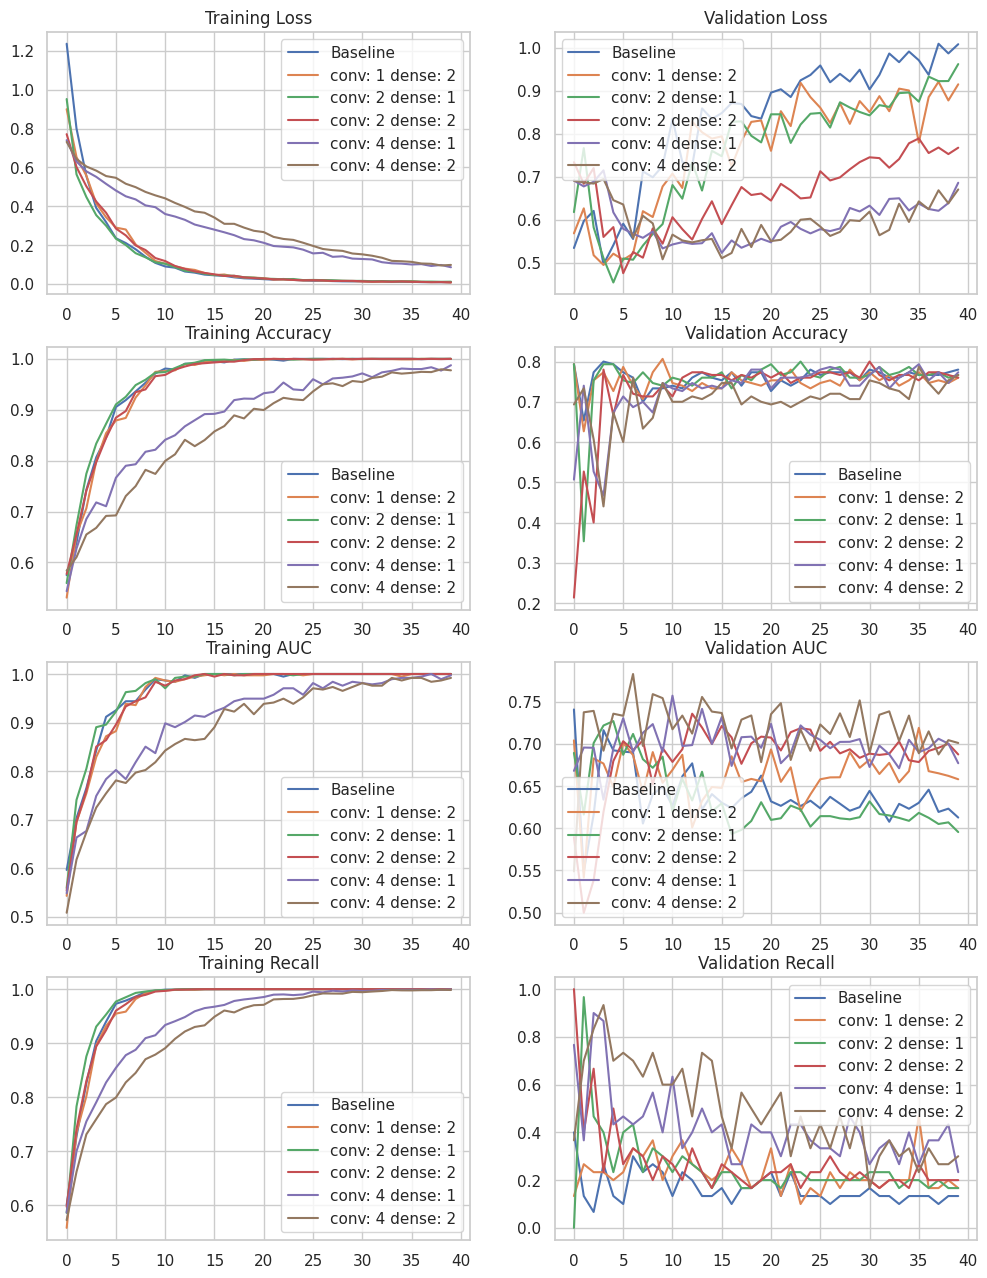

In [ ]:
plot_results(history)

### **Try activations**

---

In [ ]:
activations = ['softmax', 'sigmoid', 'tanh']  # Baseline = relu
history = baseline.copy()

for act in activations:
  model = LesionNet(hidden_act=act)
  h = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator)  
  history[act] = pd.DataFrame.from_dict(h.history)

Epoch 1/40
63/63 [==============================] - 12s 192ms/step - loss: 0.6887 - binary_accuracy: 0.6030 - precision_6: 0.1708 - recall_6: 0.2914 - auc_6: 0.5103 - val_loss: 0.6898 - val_binary_accuracy: 0.8000 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_auc_6: 0.5000
Epoch 2/40
63/63 [==============================] - 12s 183ms/step - loss: 0.6676 - binary_accuracy: 0.8140 - precision_6: 1.0000 - recall_6: 0.0053 - auc_6: 0.5199 - val_loss: 0.6843 - val_binary_accuracy: 0.8000 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_auc_6: 0.5042
Epoch 3/40
63/63 [==============================] - 12s 184ms/step - loss: 0.6452 - binary_accuracy: 0.8130 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - auc_6: 0.5133 - val_loss: 0.6790 - val_binary_accuracy: 0.8000 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_auc_6: 0.4792
Epoch 4/40
63/63 [==============================] - 12s 188ms/step - loss: 0.6286 - binary_accuracy: 0.8130 - precision

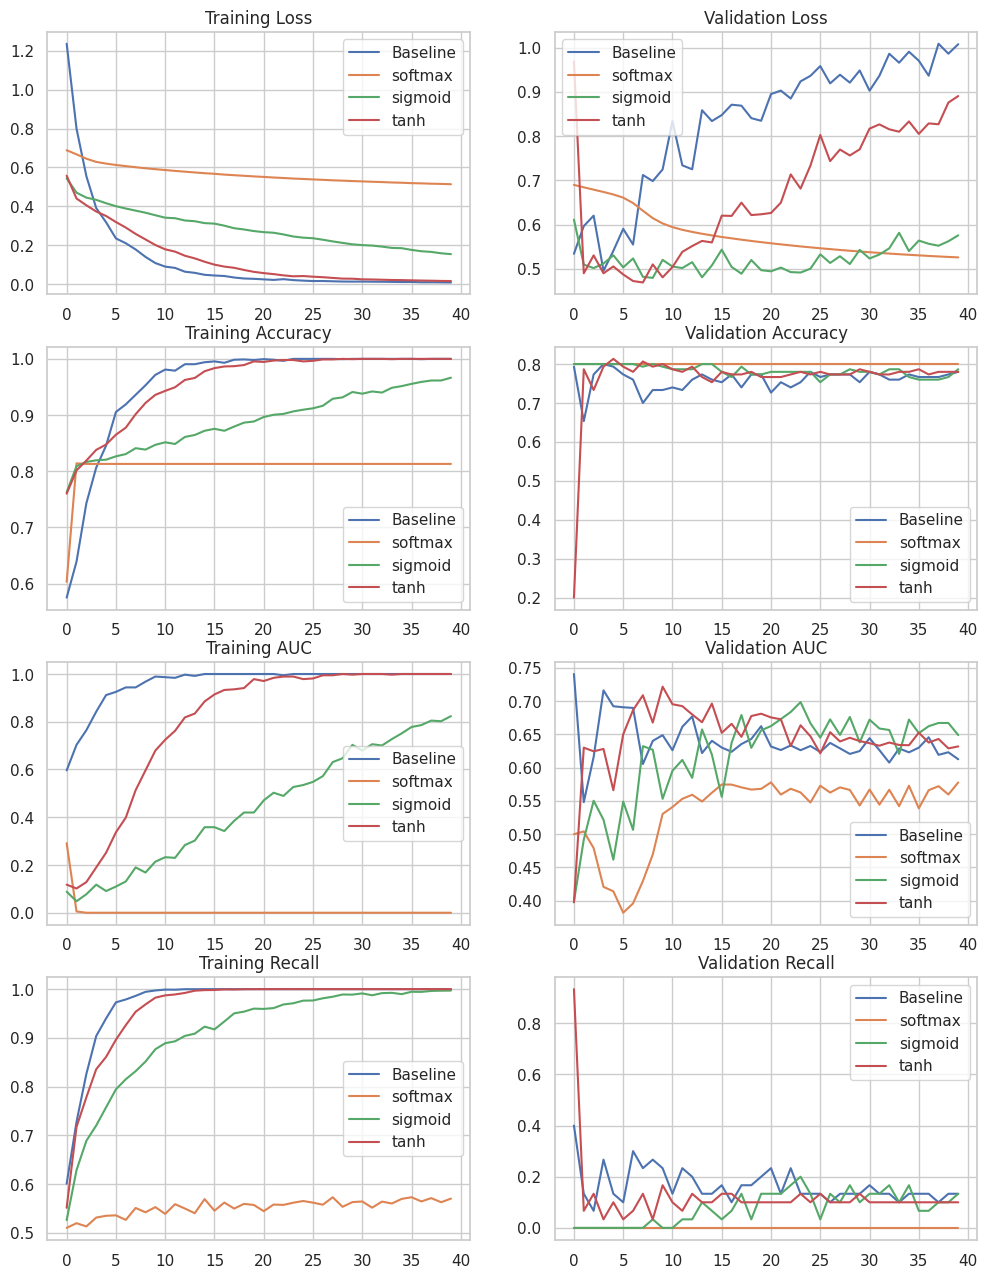

In [ ]:
plot_results(history)

###**Try initializations**

---

In [ ]:
initTypes = ["zeros", "ones", "RandomNormal"]  #  Baseline = glorot_uniform
history = baseline.copy()

for i in initTypes:
  model = LesionNet(ini=i)
  h = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, class_weight=weights)
  history[i] = pd.DataFrame.from_dict(h.history)

Epoch 1/40
63/63 [==============================] - 12s 190ms/step - loss: 0.6932 - binary_accuracy: 0.8010 - precision_9: 0.1250 - recall_9: 0.0107 - auc_9: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.8000 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_auc_9: 0.5000
Epoch 2/40
63/63 [==============================] - 11s 179ms/step - loss: 0.6932 - binary_accuracy: 0.5020 - precision_9: 0.1760 - recall_9: 0.4519 - auc_9: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.8000 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_auc_9: 0.5000
Epoch 3/40
63/63 [==============================] - 11s 179ms/step - loss: 0.6931 - binary_accuracy: 0.2330 - precision_9: 0.1848 - recall_9: 0.9091 - auc_9: 0.5000 - val_loss: 0.6932 - val_binary_accuracy: 0.2000 - val_precision_9: 0.2000 - val_recall_9: 1.0000 - val_auc_9: 0.5000
Epoch 4/40
63/63 [==============================] - 11s 180ms/step - loss: 0.6931 - binary_accuracy: 0.1870 - precision_9: 0.1870 - rec

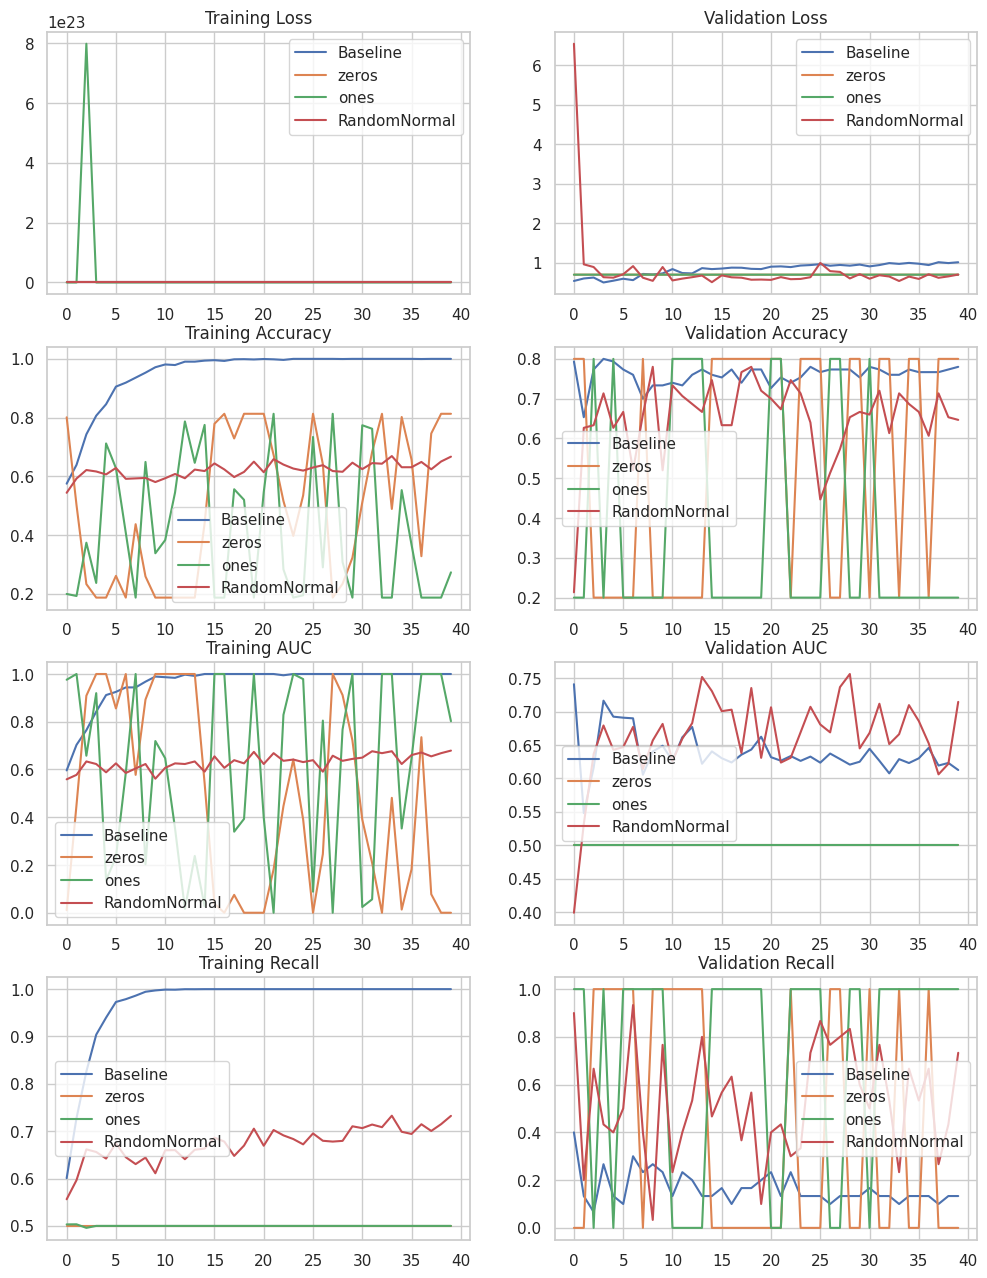

In [ ]:
plot_results(history)

###**Try optimizers**

---

In [ ]:
optimizers = {"Adam": K.optimizers.Adam(learning_rate=1e-4), 
              "Adagrad": K.optimizers.Adagrad(learning_rate=1e-4), 
              "RMSprop": K.optimizers.RMSprop(learning_rate=1e-4)}  # Baseline = SDG
history = baseline.copy()

for name, i in optimizers.items():
  print(f"Training using {name}")
  model = LesionNet(opt=i)
  h = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, class_weight=weights)  
  history[name] = pd.DataFrame.from_dict(h.history)

Training using Adam
Epoch 1/40
63/63 [==============================] - 12s 192ms/step - loss: 9.9581 - binary_accuracy: 0.5665 - precision_12: 0.2130 - recall_12: 0.4893 - auc_12: 0.5454 - val_loss: 1.5779 - val_binary_accuracy: 0.5933 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_auc_12: 0.4337
Epoch 2/40
63/63 [==============================] - 11s 182ms/step - loss: 2.1573 - binary_accuracy: 0.5425 - precision_12: 0.2530 - recall_12: 0.7406 - auc_12: 0.6459 - val_loss: 1.4771 - val_binary_accuracy: 0.7933 - val_precision_12: 0.3333 - val_recall_12: 0.0333 - val_auc_12: 0.6611
Epoch 3/40
63/63 [==============================] - 11s 181ms/step - loss: 1.2681 - binary_accuracy: 0.5790 - precision_12: 0.2724 - recall_12: 0.7487 - auc_12: 0.7100 - val_loss: 0.7594 - val_binary_accuracy: 0.7000 - val_precision_12: 0.3729 - val_recall_12: 0.7333 - val_auc_12: 0.7244
Epoch 4/40
63/63 [==============================] - 11s 182ms/step - loss: 0.7810 - binary_accuracy: 0.57

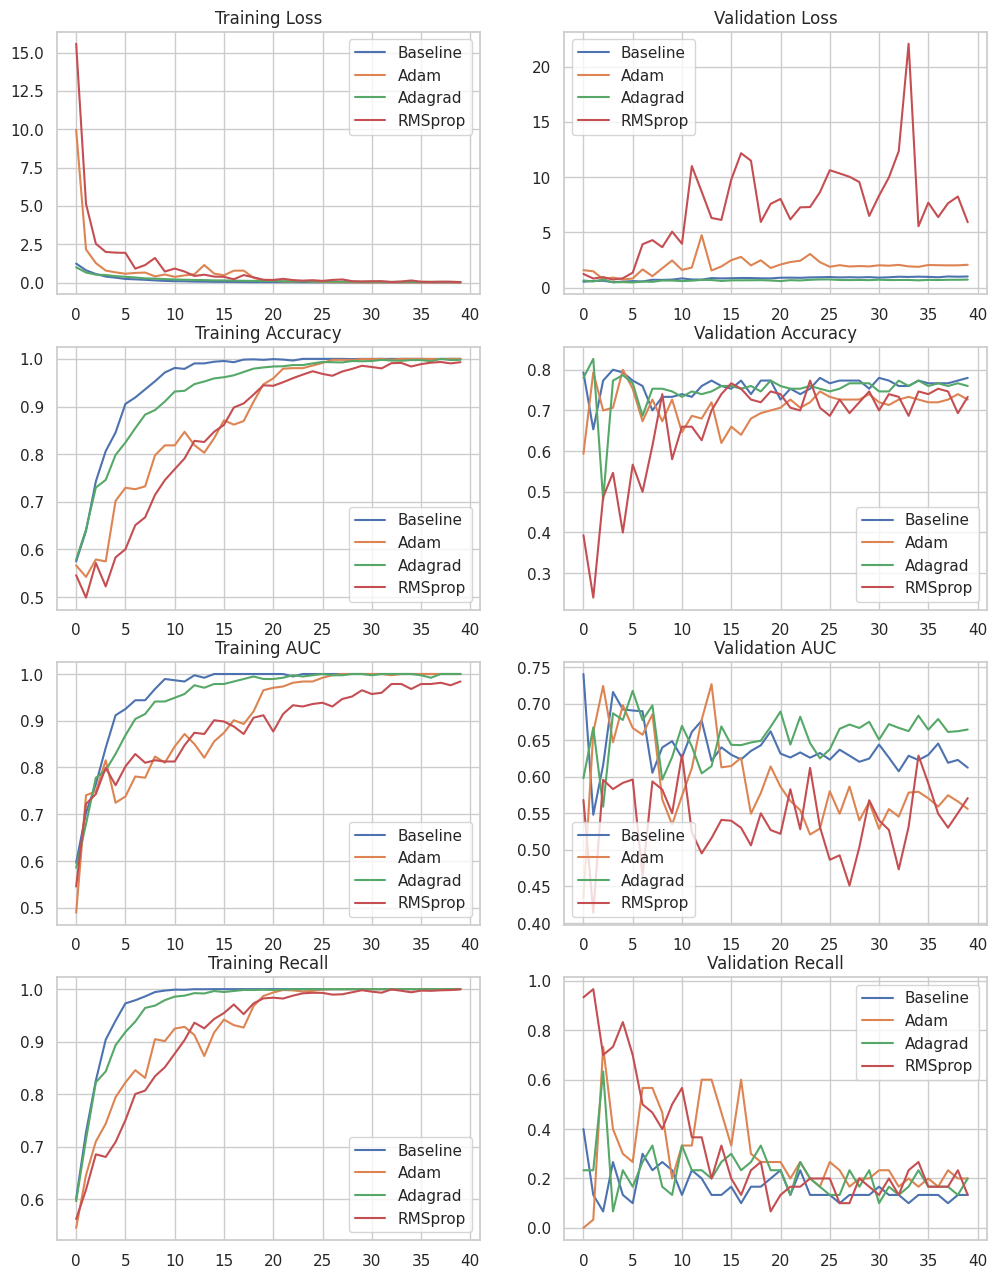

In [ ]:
plot_results(history)

###**Try regularizations**

---

In [ ]:
reg_names = ['1e-5', '1e-2', '1e-1', '1', '1.5']
history = baseline.copy()  # Baseline = no L2 reg

for reg in reg_names:
  model = LesionNet(reg=K.regularizers.l2(float(reg)))
  h = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, class_weight=weights)  
  history[reg] = pd.DataFrame.from_dict(h.history)

Epoch 1/40
63/63 [==============================] - 13s 213ms/step - loss: 1.5242 - binary_accuracy: 0.5275 - precision_1: 0.2102 - recall_1: 0.5535 - auc_1: 0.5585 - val_loss: 0.8420 - val_binary_accuracy: 0.4267 - val_precision_1: 0.2021 - val_recall_1: 0.6333 - val_auc_1: 0.5243
Epoch 2/40
63/63 [==============================] - 13s 199ms/step - loss: 0.9126 - binary_accuracy: 0.6150 - precision_1: 0.2745 - recall_1: 0.6444 - auc_1: 0.6733 - val_loss: 0.5444 - val_binary_accuracy: 0.7667 - val_precision_1: 0.2222 - val_recall_1: 0.0667 - val_auc_1: 0.5396
Epoch 3/40
63/63 [==============================] - 12s 193ms/step - loss: 0.5309 - binary_accuracy: 0.6840 - precision_1: 0.3475 - recall_1: 0.7861 - auc_1: 0.8028 - val_loss: 0.5330 - val_binary_accuracy: 0.7000 - val_precision_1: 0.3404 - val_recall_1: 0.5333 - val_auc_1: 0.6879
Epoch 4/40
63/63 [==============================] - 12s 194ms/step - loss: 0.4910 - binary_accuracy: 0.7470 - precision_1: 0.4125 - recall_1: 0.8316 - 

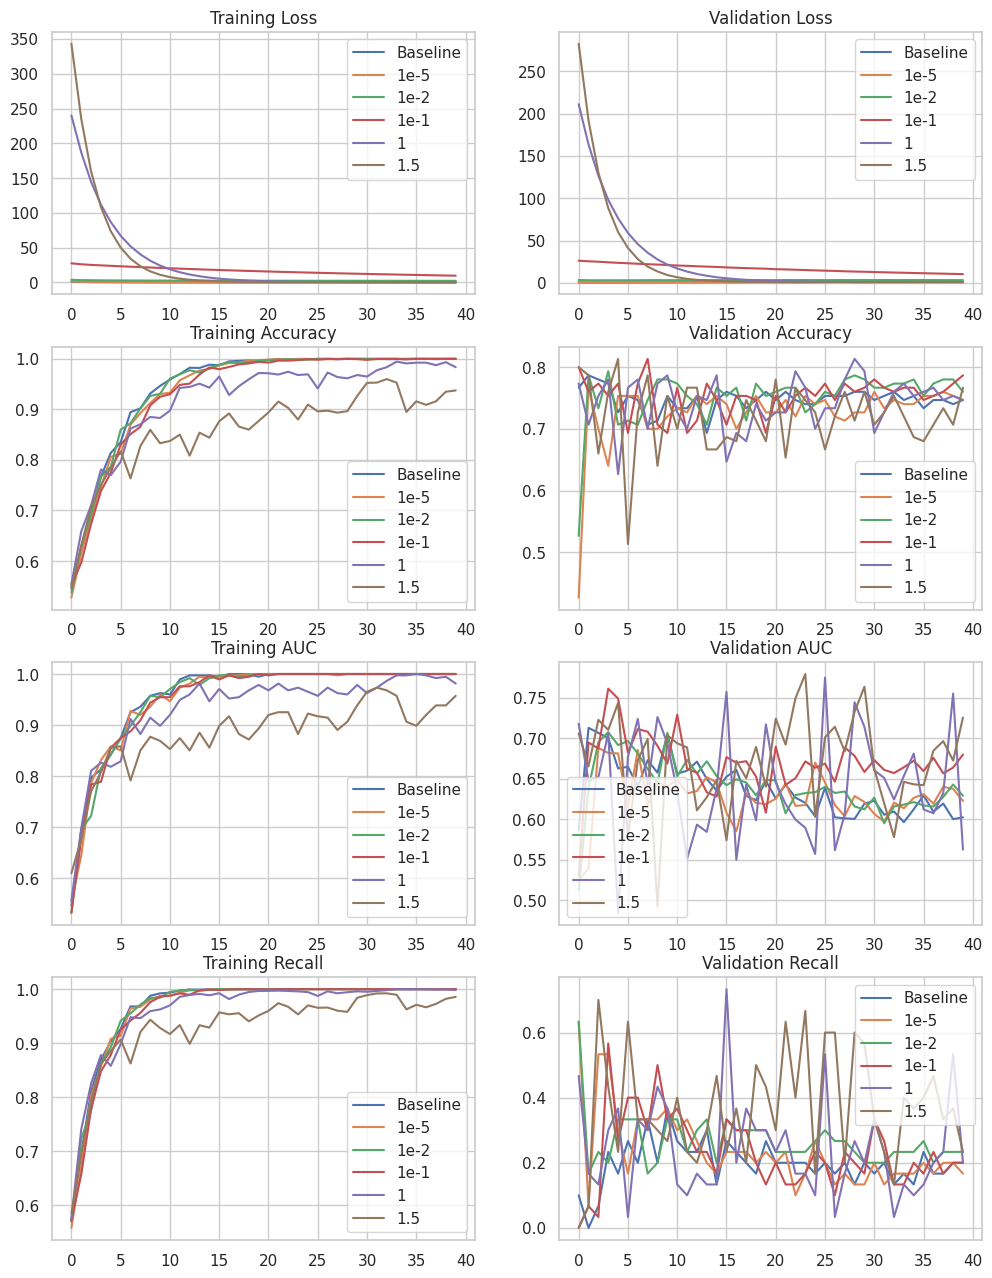

In [ ]:
plot_results(history)

### **Try augmentation**

In [ ]:
train_datagenerator_augmentation = ImageDataGenerator(
                                         rescale=1.0/255.0,
                                         rotation_range=30,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True
                                         )

train_generator_augmentation = train_datagenerator_augmentation.flow_from_directory('isic2017-train',
                                                          target_size=(299,299),
                                                          batch_size=32,
                                                          class_mode='binary')

Found 2000 images belonging to 2 classes.


Epoch 1/40
63/63 [==============================] - 44s 691ms/step - loss: 1.4184 - binary_accuracy: 0.5490 - precision_6: 0.2179 - recall_6: 0.5455 - auc_6: 0.5708 - val_loss: 0.4921 - val_binary_accuracy: 0.8000 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_auc_6: 0.6025
Epoch 2/40
63/63 [==============================] - 43s 682ms/step - loss: 1.0261 - binary_accuracy: 0.5520 - precision_6: 0.2380 - recall_6: 0.6337 - auc_6: 0.6074 - val_loss: 0.5499 - val_binary_accuracy: 0.8133 - val_precision_6: 0.5833 - val_recall_6: 0.2333 - val_auc_6: 0.6711
Epoch 3/40
63/63 [==============================] - 43s 681ms/step - loss: 0.8240 - binary_accuracy: 0.5455 - precision_6: 0.2405 - recall_6: 0.6631 - auc_6: 0.6145 - val_loss: 0.5529 - val_binary_accuracy: 0.7400 - val_precision_6: 0.2632 - val_recall_6: 0.1667 - val_auc_6: 0.6426
Epoch 4/40
63/63 [==============================] - 42s 672ms/step - loss: 0.7365 - binary_accuracy: 0.5600 - precision_6: 0.2548 - recall_6: 0

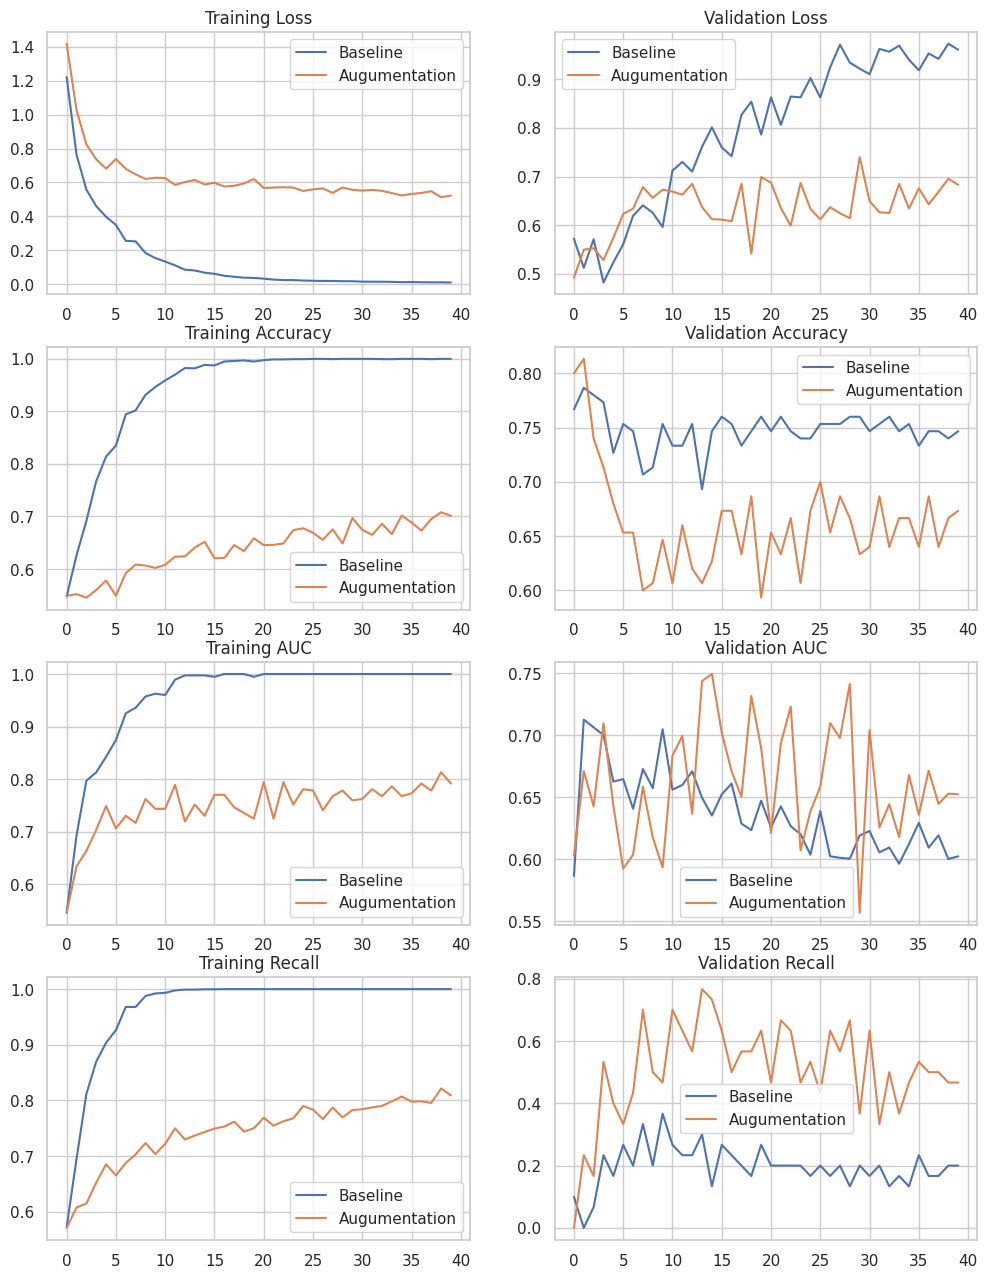

In [ ]:
history = baseline.copy()

model = LesionNet()
h = model.fit(train_generator_augmentation, epochs=EPOCHS, validation_data=validation_generator, class_weight=weights)
history["Augumentation"] = pd.DataFrame.from_dict(h.history)

plot_results(history)

### **Try a combination**

In [ ]:
history = {}
EPOCHS = 150

# Test Improved model with 60 Epochs
improved_model = LesionNet(
                              opt=None,
                              hidden_act='relu',
                              output_act='sigmoid',
                              ini='glorot_uniform',
                              conv_layers=4,
                              dense_layers=2,
                              reg=K.regularizers.l2(1e-2)
)
h = improved_model.fit(train_generator_augmentation, epochs=EPOCHS, validation_data=validation_generator, class_weight=weights)
history["Improved"] = pd.DataFrame.from_dict(h.history)

Epoch 1/150
63/63 [==============================] - 43s 680ms/step - loss: 6.7794 - binary_accuracy: 0.5650 - precision_1: 0.2269 - recall_1: 0.5508 - auc_1: 0.5738 - val_loss: 6.7358 - val_binary_accuracy: 0.6600 - val_precision_1: 0.2667 - val_recall_1: 0.4000 - val_auc_1: 0.6046
Epoch 2/150
63/63 [==============================] - 43s 683ms/step - loss: 6.7254 - binary_accuracy: 0.5620 - precision_1: 0.2254 - recall_1: 0.5508 - auc_1: 0.5977 - val_loss: 6.7209 - val_binary_accuracy: 0.5067 - val_precision_1: 0.2500 - val_recall_1: 0.7333 - val_auc_1: 0.6842
Epoch 3/150
63/63 [==============================] - 43s 688ms/step - loss: 6.6993 - binary_accuracy: 0.5560 - precision_1: 0.2430 - recall_1: 0.6497 - auc_1: 0.6270 - val_loss: 6.7126 - val_binary_accuracy: 0.4533 - val_precision_1: 0.2547 - val_recall_1: 0.9000 - val_auc_1: 0.6587
Epoch 4/150
63/63 [==============================] - 43s 690ms/step - loss: 6.6553 - binary_accuracy: 0.5870 - precision_1: 0.2538 - recall_1: 0.623

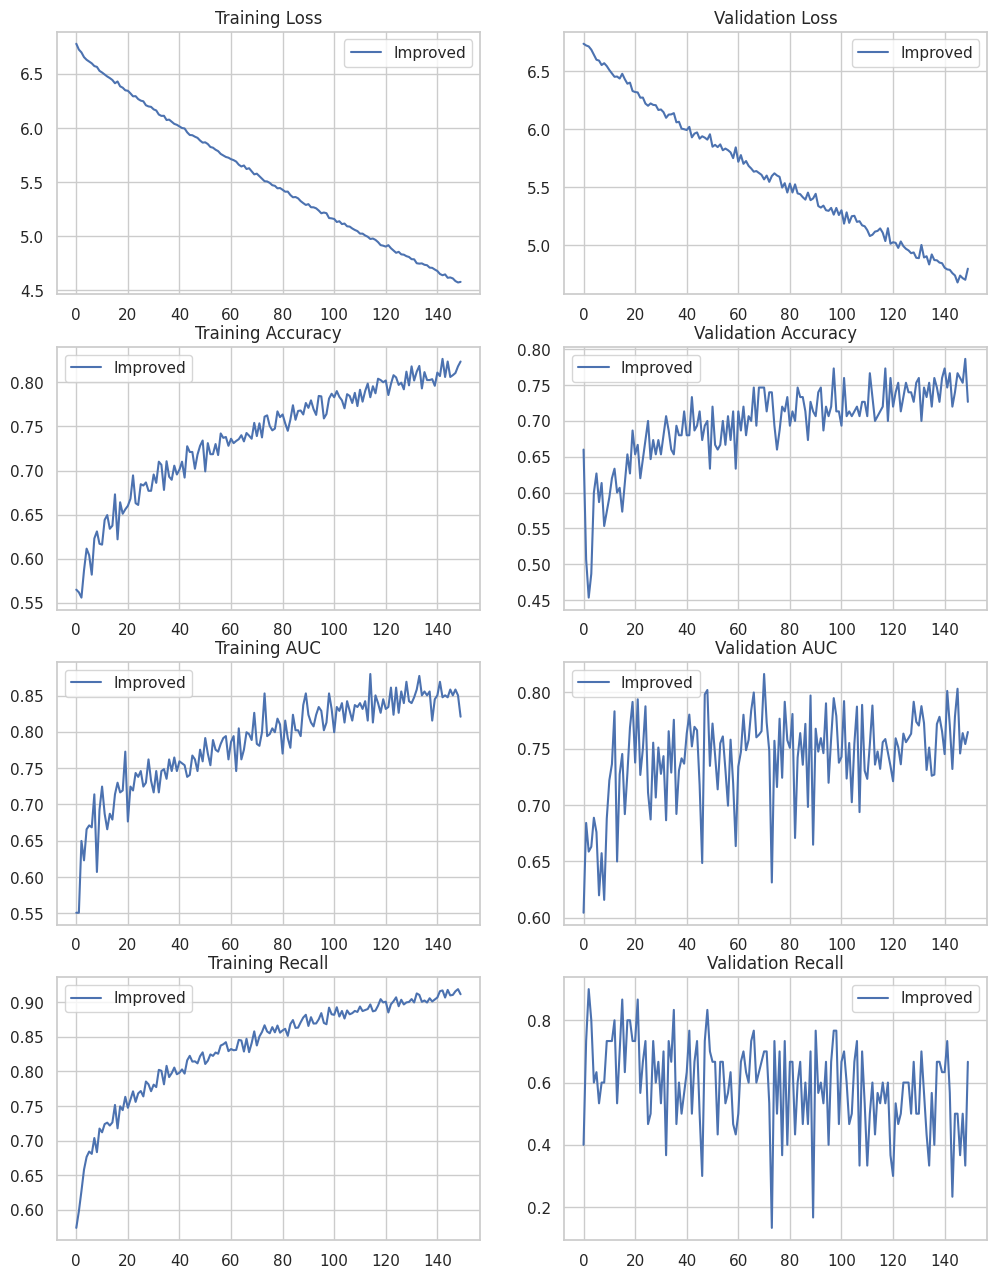

In [ ]:
plot_results(history)

*Quais são as suas impressões? O resultado melhorou em relação ao baseline? (1-2 parágrafos)*

---

A primeira variação que fizemos na rede foi adicionar progressivamente mais camadas de convolução e max pooling no topo da rede, alterando a quantidade de filtros e a dimensão do kernel em relação à primeira camada. Ademais, acrescentamos outra camada fully-connected antes da camada final de tomada de decisão e avaliamos o impacto gerado. Pudemos observar que quanto maior o número de convoluções e pooling, mais lenta foi a convergência do modelo para o local ótimo na fase de treinamento. Semelhantemente o desempenho mensurado pela AUC no treinamento foi superior quando usamos poucas camadas de convolução. Entretanto, esse cenário se inverte na etapa de validação. Quanto maior o número de camadas intercaladas mais resiliência a rede teve para rotular corretamento e distinguir as novas amostras. O melhor resultado foi alcançado quando adicionamos outras 4 camadas intercaladas de convolução e pooling e 2 camadas densas na base da arquitetura. Essa discrepância significativa nos resultados obtidos no treinamento contra validação sugere que houve especialização aos dados na fase de treino, especialmente quando a complexidade da rede era menor.

Variando as funções de ativação nas camadas ocultas percebemos que tanto a sigmoide quanto a softmax obtiveram um baixo desempenho no treinamento. Atribuímos isso ao fato de ambas terem uma formulação similar na resolução de tarefas de classificação binária, além de pertencerem ao mesmo nível de funções sigmoidais. Na validação, todas as funções exceto a softmax tiveram um comportamento próximo, variando nas últimas 10 épocas entre 0.63 à 0.7 AUC. Incorporando tipos variados de inicializadores percebemos que começar os tensores com valores randômicos que obedecem uma distribuição normal ou uniforme, o modelo consegue distinguir corretamente mais de 70% das amostras. Durante o treinamento verificamos uma melhora gradual e distinta ao alterarmos os otimizadores, entretanto na validação os valores oscilaram nas iterações, mesmo assim, na média o SDG e o Adagrad performaram melhor que os demais testados. Ainda na otimização, penalizamos a rede diversificando os fatores de regularização. Observamos que quanto menor esse fator maior é a confiabilidade da predição no treinamento, todavia na validação, os maiores resultados na AUC foram com os fatores de maior grau. Devido a isso optamos por selecionar um valor mediano. Para evitar overfitting e ainda contribuir para solucionar o problema do desbalanceamento realizamos a aumentação de dados apenas no conjunto de treinamento. Nesse esquema rotacionamos, transladamos, flipamos vertical e horizontalmente e aplicamos zoom. A área abaixo da curva ROC mostrou que tal abordagem superou o modelo base em algumas iterações, porém os resultados oscilaram muito entre épocas. Por fim, testamos o arcabouço usando todos os parâmetros que conferiram o melhor desempenho na validação. Verificamos que com esses ajustes a AUC foi para cerca de 0.8, isso é, 80% dos dados foram preditos em suas devidas categorias.

### **Fine-tuning**

3. (3,0 pts) Escolha uma arquitetura cuja implementação e pesos pré-treinados na ImageNet estejam disponíveis como extratora de features. 

- (1,5 pts) Inicialmente, descarte a saída original e congele suas as camadas. Adicione uma nova camada de saída com o número de classes adequadas para este problema.


In [ ]:
# Dataset using vgg16 input process
train_datagenerator_vgg16 = ImageDataGenerator(preprocessing_function=K.applications.vgg16.preprocess_input,
                                         rotation_range=30,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True)
train_generator_vgg16 = train_datagenerator.flow_from_directory('isic2017-train',
                                                          target_size=(299,299),
                                                          batch_size=32,
                                                          class_mode='binary')

validation_datagenerator_vgg16 = ImageDataGenerator(preprocessing_function=K.applications.vgg16.preprocess_input)
validation_generator_vgg16 = validation_datagenerator.flow_from_directory('isic2017-val',
                                                          target_size=(299,299),
                                                          batch_size=32,
                                                          class_mode='binary')

test_datagenerator_vgg16 = ImageDataGenerator(preprocessing_function=K.applications.vgg16.preprocess_input)
test_generator_vgg16 = train_datagenerator.flow_from_directory('isic2017-test',
                                                          target_size=(299,299),
                                                          batch_size=32,
                                                          class_mode='binary')

# Importing VGG16 Model with imagenet weights
base_model = K.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freezing model's layers
for layer in base_model.layers:
    layer.trainable = False

model_vgg16 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=K.regularizers.l2(1e-2)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=K.regularizers.l2(1e-2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_vgg16.summary()

Found 2000 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 36,212,033
Trainable params: 21,497,345
Non-train

In [ ]:
history = {}
opt = K.optimizers.SGD(learning_rate=1e-4, momentum=0.9, decay=1e-6)
model_vgg16.compile(optimizer=opt, loss='binary_crossentropy', metrics=[K.metrics.BinaryAccuracy(), 
                                                                        K.metrics.Precision(), 
                                                                        K.metrics.Recall(),
                                                                        K.metrics.AUC()])

h = model_vgg16.fit(train_generator_vgg16,
                    batch_size=32,
                    epochs=100,
                    validation_data=validation_generator_vgg16,
                    class_weight=weights)

history["VGG16"] = pd.DataFrame.from_dict(h.history)

Epoch 1/100
63/63 [==============================] - 19s 302ms/step - loss: 12.2316 - binary_accuracy: 0.8415 - precision_2: 0.5482 - recall_2: 0.8663 - auc_2: 0.9258 - val_loss: 12.4669 - val_binary_accuracy: 0.7600 - val_precision_2: 0.3929 - val_recall_2: 0.3667 - val_auc_2: 0.5993
Epoch 2/100
63/63 [==============================] - 18s 287ms/step - loss: 12.2359 - binary_accuracy: 0.8145 - precision_2: 0.5024 - recall_2: 0.8422 - auc_2: 0.9023 - val_loss: 12.4300 - val_binary_accuracy: 0.7533 - val_precision_2: 0.3871 - val_recall_2: 0.4000 - val_auc_2: 0.6056
Epoch 3/100
63/63 [==============================] - 17s 275ms/step - loss: 12.1774 - binary_accuracy: 0.8320 - precision_2: 0.5309 - recall_2: 0.8717 - auc_2: 0.9240 - val_loss: 12.3789 - val_binary_accuracy: 0.7867 - val_precision_2: 0.4444 - val_recall_2: 0.2667 - val_auc_2: 0.6028
Epoch 4/100
63/63 [==============================] - 17s 273ms/step - loss: 12.1436 - binary_accuracy: 0.8440 - precision_2: 0.5525 - recall_2

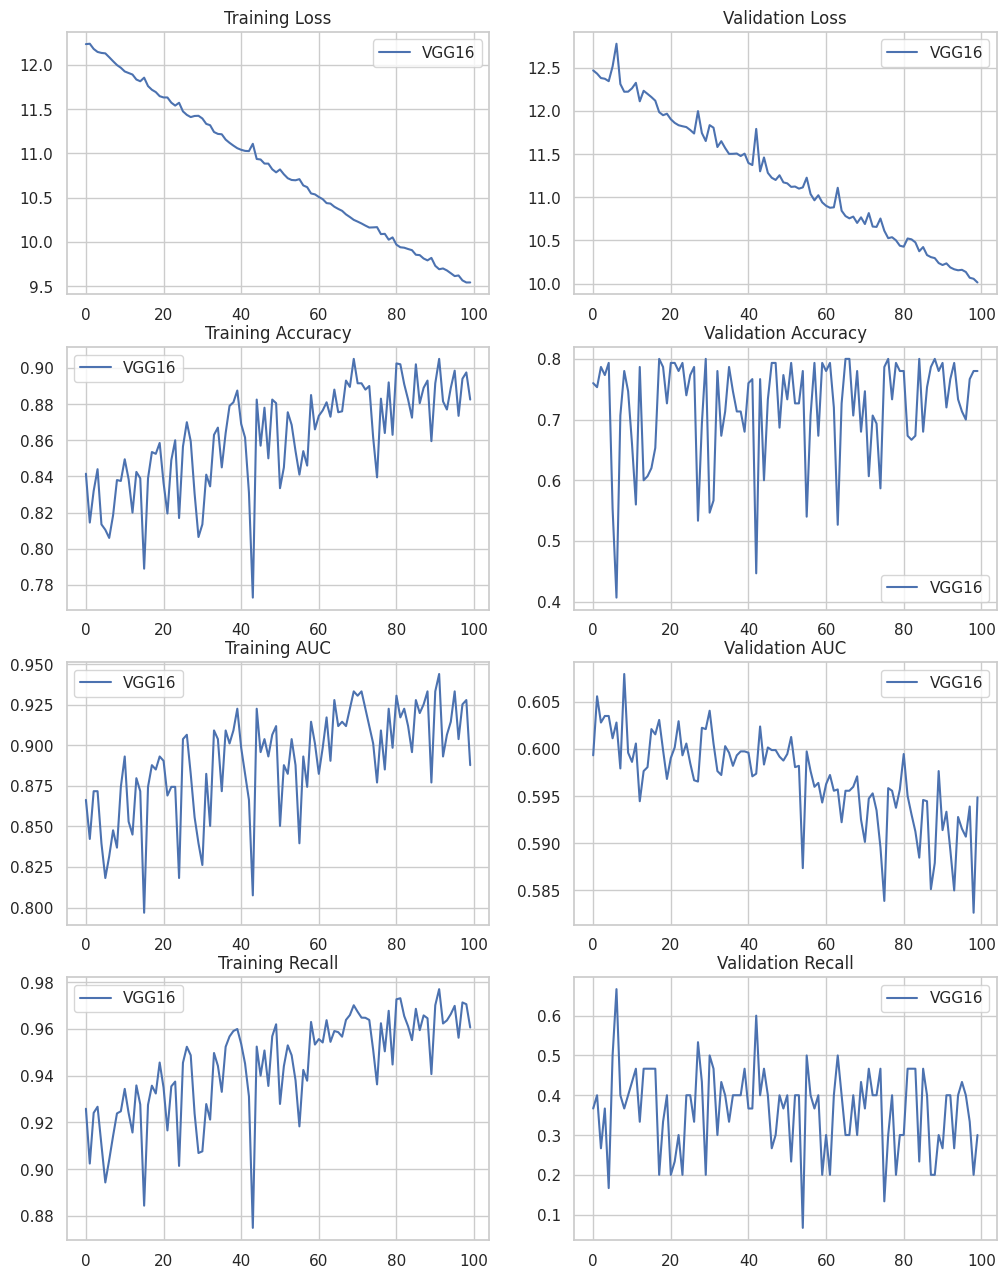

In [ ]:
plot_results(history)

> Quais são as suas impressões? O resultado melhorou em relação à questão anterior? Como foi o tempo de treinamento? Houve overfitting? (1-2 parágrafos) 

---

Escolhemos a arquitetura VGG-16 para a etapa de fine-tuning porque, embora seja uma rede profunda, tem uma quantidade moderada de hiperparâmetros e, além disso, essa topologia de rede segue o padrão convolução e pooling, semelhantemente as redes testadas acima, exceto pela dimensão. Usando os pesos originais da VGG-16 treinados na ImageNet não conseguimos bons resultados, uma vez que essa base de dados é designada para tarefas de recognição de objetos e não lesões em pele. A precisão da predição no treino foi alta, entrementes essa premissa não é verdadeira para a validação, indicando que o modelo super especializou às amostras.

Embora a perda no conjunto de validação tenha caido ao longo de todo o treinamento, experimentos mais longos não mostraram melhora significativa em nenhuma das métricas.

Uma vez que a maioria das camadas estão congeladas, o número de parâmetros que devem ser treinados é razoavelmente menor além de tornar a rede "treinável" menos profunda, o que reduz o tempo requerido para uma época. Entretanto, a quantidade de parâmetros ainda é grande (mais de 21 milhões) deixando a convergência do modelo mais lenta.

- (1,5 pts) Descongele as camadas da rede extratora de features e realize o fine-tuning da rede, continuando o treinamento.

In [ ]:
# Unfreezing base model's layers
for layer in base_model.layers:
    layer.trainable = True

# Using a lower learning rate for fine tunning
opt = K.optimizers.SGD(learning_rate=1e-6, momentum=0.9, decay=1e-6)
model_vgg16.compile(optimizer=opt, loss='binary_crossentropy', metrics=[K.metrics.BinaryAccuracy(), 
                                                                        K.metrics.Precision(), 
                                                                        K.metrics.Recall(),
                                                                        K.metrics.AUC()])

h = model_vgg16.fit(train_generator_vgg16,
                    batch_size=32,
                    epochs=50,
                    validation_data=validation_generator_vgg16,
                    class_weight=weights)
history["VGG16"] = pd.concat([history["VGG16"], pd.DataFrame.from_dict(h.history)], ignore_index=True)

Epoch 1/50
63/63 [==============================] - 53s 844ms/step - loss: 9.4720 - binary_accuracy: 0.9300 - precision_3: 0.7448 - recall_3: 0.9519 - auc_3: 0.9854 - val_loss: 10.0355 - val_binary_accuracy: 0.7667 - val_precision_3: 0.4138 - val_recall_3: 0.4000 - val_auc_3: 0.5946
Epoch 2/50
63/63 [==============================] - 51s 805ms/step - loss: 9.4686 - binary_accuracy: 0.9260 - precision_3: 0.7325 - recall_3: 0.9519 - auc_3: 0.9855 - val_loss: 10.0377 - val_binary_accuracy: 0.7600 - val_precision_3: 0.3929 - val_recall_3: 0.3667 - val_auc_3: 0.5954
Epoch 3/50
63/63 [==============================] - 51s 808ms/step - loss: 9.4641 - binary_accuracy: 0.9315 - precision_3: 0.7474 - recall_3: 0.9572 - auc_3: 0.9868 - val_loss: 10.0296 - val_binary_accuracy: 0.7600 - val_precision_3: 0.3750 - val_recall_3: 0.3000 - val_auc_3: 0.5861
Epoch 4/50
63/63 [==============================] - 51s 805ms/step - loss: 9.4623 - binary_accuracy: 0.9310 - precision_3: 0.7448 - recall_3: 0.9599

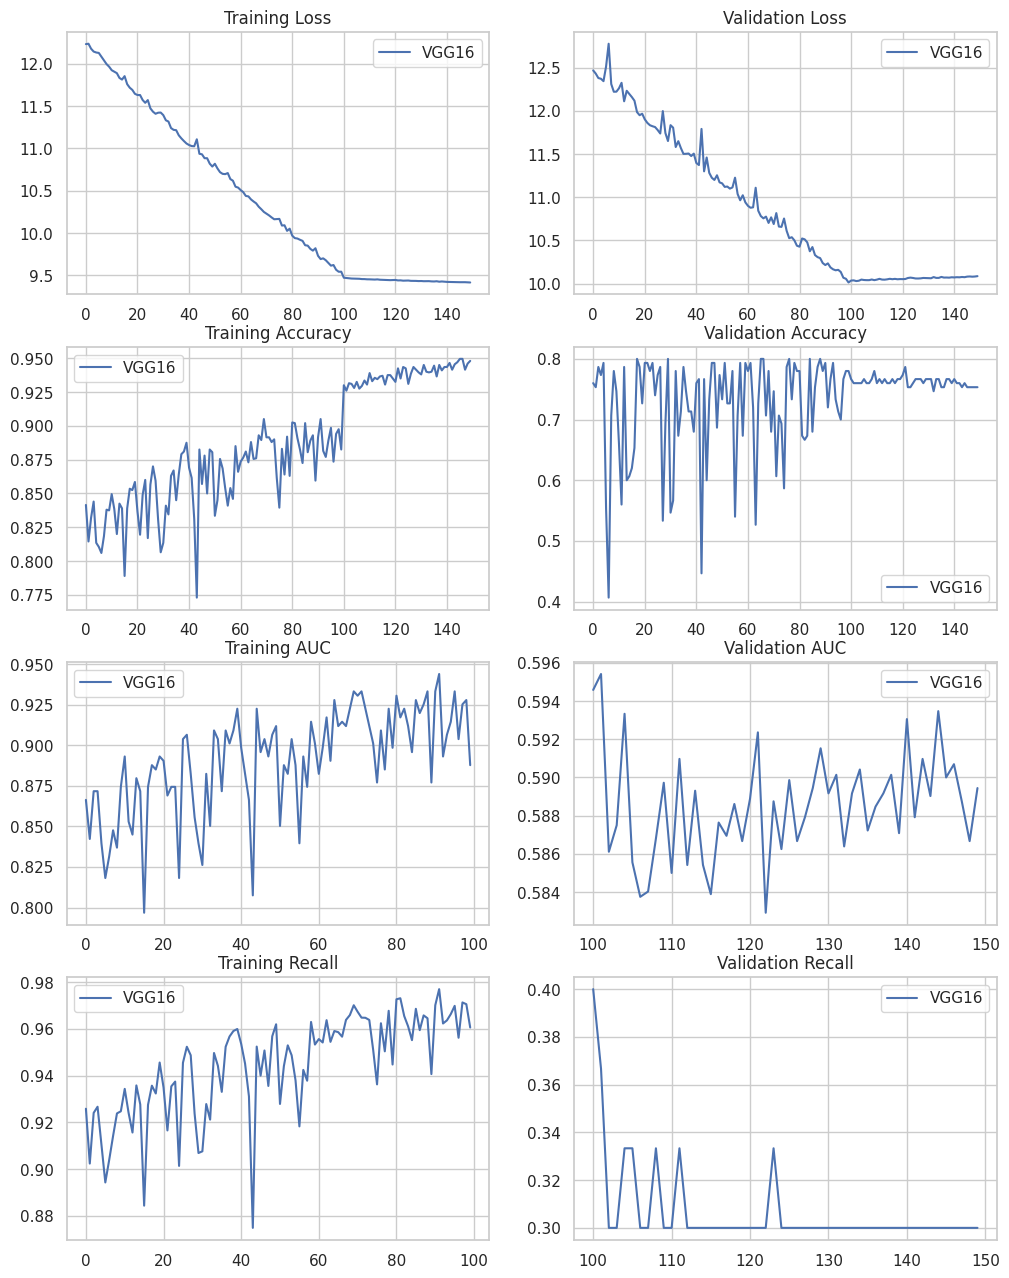

In [ ]:
plot_results(history)

> Quais são as suas impressões? O resultado melhorou em relação à questão anterior? Como foi o tempo de treinamento? Houve overfitting? (1-2 parágrafos)

---

Descongelando as camadas da rede e continuando o treinamento com uma taxa de aprendizagem menor, esperávamos que conseguiríamos superar os demais experimentos, contudo nessa abordagem obtivemos os piores resultados. No treinamento o arcabouço alcançou 95% de acurácia, todavia na validação os resultados caíram drasticamente. Indicando novamente overffiting. Acreditamos tal cenário dá-se ao fato de termos uma rede robusta com alta capacidade entrópica processando poucas amostras de dados de um problema complexo. Por conseguinte, a rede se especializa aos dados de treinamento e não consegue generalizar para as novas imagens. Notamos que esse experimento requereu maior tempo de processamento. Essa qualidade é explicada porque a rede contém mais camadas e conexões mais intrincadas que nas arquiteturas anteriores. 

4. (0,5 pts) Plote os gráficos da função de loss × número de épocas, para o treino e validação de cada modelo gerado. Houve overfitting?

---
**Os gráficos foram plotados ao longo dos experimentos**

> Quais são as suas impressões? Houve overfitting? (1-2 parágrafos)

---

Notamos que na validação, de modo geral, a rede melhorou até certo ponto, no que diz respeito a acurácia, e depois se manteve inalterado até o fim. Enquanto isso, a loss aumentava. Esse cenário é tipicamente visto em modelos que super especializam os dados de treinamento, porém não generalizam e falham ao classificar novos dados. Ademais, verificamos que existem picos acentuados nos gráficos de acurácia, hora o modelo classifica com 80% acurácia, mas iterações a frente obtém 20% acurácia. Atribuímos isso a presença de overffiting no modelo e a distribuição desproporcional das amostras entre as classes presentes.

Essa especialização pode ser claramente vista no gráfico da loss gerado na durante o treinamento da VGG-16 com os dados de melanoma. Tanto a loss do treino quanto da validação tem um comportamento muito similar, mas nas últimas épocas percebemos um aumento progressivo do erro.

5. (0,5 pts) Avalie o melhor modelo no conjunto de teste. Obs: Avaliação no conjunto de teste só pode ser executada uma única vez.

---

Os resultados alcançados no conjunto de teste evidenciam a complexidade da tarefa. Da topologia inicialmente proposta, simples com poucas camadas, para um arcabouço com maior complexidade, ou seja, profundo, granjeamos cerca de 6 pontos percentuais na AUC. O valor baixo de recall do baseline mostra que a rede tem baixa completude. Na arquitetura melhorada conseguimos aumentar tal fator, mas ainda a precisão foi baixa. Utilizando a VGG como extratora de características apenas, não conseguimos nenhum benefício, por outro lado, angariamos mais de 10 pontos percentuais em relação ao modelo base quando continuamos o treinamento usando os dados de lesões de pele. Entretanto, a loss se manteve alta, evidenciando a presença de especialização no treino.

In [ ]:
# Baseline model
baseline_model.evaluate(test_generator)

19/19 [==============================] - 3s 158ms/step - loss: 0.7977 - binary_accuracy: 0.7967 - precision: 0.4510 - recall: 0.1966 - auc: 0.6517


[0.7977245450019836,
 0.79666668176651,
 0.45098039507865906,
 0.19658119976520538,
 0.6517404317855835]

In [ ]:
# Improved model
improved_model.evaluate(test_generator)

19/19 [==============================] - 3s 164ms/step - loss: 4.8969 - binary_accuracy: 0.7067 - precision_1: 0.3628 - recall_1: 0.6667 - auc_1: 0.7157


[4.896899223327637,
 0.7066666483879089,
 0.36279070377349854,
 0.6666666865348816,
 0.7157191038131714]

In [ ]:
# VGG16 transfer model
model_vgg16.evaluate(test_generator)

19/19 [==============================] - 6s 317ms/step - loss: 9.8255 - binary_accuracy: 0.7667 - precision_3: 0.4109 - recall_3: 0.4530 - auc_3: 0.7373


[9.825540542602539,
 0.7666666507720947,
 0.41085270047187805,
 0.45299145579338074,
 0.7372547388076782]

6. (2,0 pts) Elabore uma conclusão discutindo os experimentos. 

---

Nesse trabalho exploramos diversas abordagens para solucionar o problema de identificação de lesões de pele em imagens. 

O primeiro desafio foi lidar com o desbalanceamento dos dados, para isso ponderamos as amostras durante o treino e fizemos a aumentação de dados no mesmo conjunto. Notamos que tais estratégias foram fundamentais para conseguirmos melhores resultados. 

Além disso, testamos vários parâmetros de inicialização, regularização, etc. Notamos que comumente  não houve diferenças significativas ao alterarmos tais parâmetros, no entanto, algumas diferenças sutis contribuíram para que melhorássemos o arcabouço inicial. 

Considerando a complexidade da tarefa concluímos que o uso da transferência de aprendizagem é uma técnica fundamental para economizar custo computacional uma vez que, ao invés de se utilizar uma rede com pesos aleatórios, inicia-se com uma rede que já é capaz de extrair certas características da imagem, porém a técnica em si não é garantia de bons resultados principalmente se o modelo não tiver sido treinado em dados do mesmo domínio.

A complexidade da rede não é sinônimo de alto desempenho, principalmente quando não há uma massiva quantidade de dados ou transferência de aprendizagem adequada ao problema em questão. Quanto maior a capacidade da rede, mais fácil é a ocorrência de overfit, enquanto uma rede de baixa capacidade dificilmente conseguirá aprender os padrões que, de fato, levam a correta classificação. Achar a capacidade ótima de um modelo, entretanto, está muito longe de ser uma tarefa trivial.